# 前處理-資料清理
1. missing data
    - 平均值、標準差、屆在平均值與標準差之間的亂數
    
2. range差異過大的資料
    - 偵測(identity): PCA
    
    - 處理: 取log e.g. 10^1 => 1, 10^6 => 6
    
4. 資料不一致的問題
    - domain knowledge e.g. 年紀為負的
    
5. 正規化(Normalize)
    - L1 Norm(穩定: 水平調整較少): 
        - $\|𝑥\|_{1𝑖} = {𝑥_𝑖}{\sum{|𝑥_𝑖|}}$
    - L2 Norm(強健: 較能對抗outlier): 
        - $\|𝑥\|_{2𝑖}=\dfrac{𝑥_𝑖}{\sqrt{(\sum{𝑥_𝑖^2)}}}$

6. 類別型資料的處理
    - 自然語言(NLP): 先轉成類別型資料
    - onehot encoding
    
| 0 | 1 | 2 |
|---|---|---|
|[1,0,0]|[0,1,0]|[0,0,1]|

7. Feature 產生工具
    - PolynomialFeatures: (𝑋_1, 𝑋_2)=> (1, 𝑋_1, 𝑋_2, 𝑋_1^2, 𝑋_1 𝑋_2, 𝑋_2^2)
    
8. 議題:
    - 請問取log與normalize有什麼差別?


# IMPORT & DATA

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import os 
import random
import math

In [2]:
df = pd.read_csv('train.csv')

# 請查看df.info()
# 並找出共有幾種型別，以及哪一些欄位有null值
#=============your works starts===============#
df_info = df.info()
#==============your works ends================#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
# 請查看df.describe()
# 請透過mean關注每一個變數的scale
#=============your works starts===============#
df_describe = df.describe()
#==============your works ends================#
df_describe

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#請透過head()查看df的頭5行
#=============your works starts===============#
df_head = df.head()
#==============your works ends================#

df_head

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# PREPROCESSING

## Age - Fill in missing values

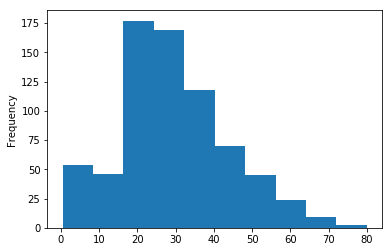

In [5]:
# 查看Age的分布狀況(hint: df['Age'].plot('hist'))
#=============your works starts===============#
age_ax = df['Age'].plot('hist')
#==============your works ends================#

plt.show()

In [6]:
# 作法一: 取平均值
#=============your works starts===============#
avg_age = df['Age'].mean() 
#==============your works ends================#


print("avg_age", avg_age) 
# avg_age 29.69911764705882

avg_age 29.69911764705882


In [7]:
# 作法二: 取中位數
#=============your works starts===============#
median_age = df['Age'].median()
#==============your works ends================#


print("median_age", median_age) 
# median_age 28.0

median_age 28.0


In [8]:
# 作法三: 用相同的分布產生亂數塞入(hint:使用np.random.randint)
std = df['Age'].std()
mean = df['Age'].mean()
size = len(df[pd.isnull(df['Age'])])
np.random.seed(1212)
#=============your works starts===============#
random_age = np.random.randint(mean - std, mean + std, size=size)
#==============your works ends================#


print("random_age", random_age) 
print("len(random_age)", len(random_age)) 
# random_age [23 41 37 17 31 20 28 24 16 42 33 19 22 20 29 15 32 16 35 40 35 34 26 27
# len(random_age) 177

random_age [23 41 37 17 31 20 28 24 16 42 33 19 22 20 29 15 32 16 35 40 35 34 26 27
 37 28 30 23 31 33 42 30 25 21 29 15 21 16 39 39 21 31 31 37 31 30 23 41
 30 35 33 21 31 28 39 37 31 29 29 40 16 43 20 29 36 22 27 41 32 24 35 23
 29 43 33 43 31 34 34 28 27 40 29 35 27 20 40 37 16 29 29 39 20 17 20 35
 24 42 34 33 26 38 42 31 30 40 34 16 35 16 34 24 43 29 22 29 20 43 29 38
 37 39 35 42 40 19 32 17 25 36 15 26 31 23 19 24 34 39 39 19 17 28 16 35
 20 16 29 18 34 43 16 28 30 42 27 25 36 19 22 43 37 38 30 15 32 38 41 21
 26 33 20 19 21 29 40 30 28]
len(random_age) 177


In [9]:
df['avg_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'avg_age'] = avg_age
df['median_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'median_age'] = median_age
df['random_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'random_age'] = random_age

df.loc[pd.isnull(df['Age']), ['avg_age', 'median_age', 'random_age']].head()

,avg_age,median_age,random_age
5,29.699118,28.0,23.0
17,29.699118,28.0,41.0
19,29.699118,28.0,37.0
26,29.699118,28.0,17.0
28,29.699118,28.0,31.0


## Age - Normalize
- L1 Normalization: $|| x ||_2 = \sqrt{\left(\sum_i x_i^2\right)} = \sqrt{x_1^2 + x_2^2 + \ldots + x_i^2}$
- L2 Normalization: $|| x ||_1 = \sum_i |x_i| = |x_1| + |x_2| + \ldots + |x_i|$
- difference
![l1_l2_norm](./imgs/l1_l2_norm.png)

In [10]:
# 請寫出L1 Normaliaze的function
def normalize_l1(X):
    """if type(X) == np.array, and X has two dimensiions"""
    #=============your works starts===============#
    l1_x = np.sum(X)
    X = X / l1_x
    #==============your works ends================#
    return X

X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]
X_normalized = normalize_l1(X)
print(X_normalized)
# [[ 0.25 -0.25  0.5 ]
#  [ 0.5   0.    0.  ]
#  [ 0.    0.25 -0.25]]

[[ 0.25 -0.25  0.5 ]
 [ 0.5   0.    0.  ]
 [ 0.    0.25 -0.25]]


In [11]:
# 請寫出L2 Normaliaze的function
def normalize_l2(X):
    """if type(X) == np.array, and X has two dimensiions"""
    #=============your works starts===============#
    l2_x = np.sqrt(np.sum(np.square(X)))
    X = X / l2_x
    #==============your works ends================#
    return X

X_normalized = normalize_l2(X)
print(X_normalized)
# [[ 0.28867513 -0.28867513  0.57735027]
#  [ 0.57735027  0.          0.        ]
#  [ 0.          0.28867513 -0.28867513]]

[[ 0.28867513 -0.28867513  0.57735027]
 [ 0.57735027  0.          0.        ]
 [ 0.          0.28867513 -0.28867513]]


In [12]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

# 請使用preprocessing.normalize(X, norm='l1')比較，與我們自己寫的normalize function有什麼不同
#=============your works starts===============#
X_normalized = preprocessing.normalize(X, norm='l1')
#==============your works ends================#

print(X_normalized)
# sklearn l1_norm
# [[ 0.25 -0.25  0.5 ]
#  [ 1.    0.    0.  ]
#  [ 0.    0.5  -0.5 ]]


[[ 0.25 -0.25  0.5 ]
 [ 1.    0.    0.  ]
 [ 0.    0.5  -0.5 ]]


In [13]:
avg_age_l1 = normalize_l1(df['avg_age'].values)
avg_age_l2 = normalize_l2(df['avg_age'].values)

df['avg_age_l1'] = avg_age_l1
df['avg_age_l2'] = avg_age_l2

df[['avg_age', 'avg_age_l1', 'avg_age_l2']].head()

,avg_age,avg_age_l1,avg_age_l2
0,22.0,0.000831,0.022735
1,38.0,0.001436,0.039270
2,26.0,0.000983,0.026869
3,35.0,0.001323,0.036170
4,35.0,0.001323,0.036170


## Cabin - NLP category

In [14]:
# 整理出每一個Cabin的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_cabin_counter = sorted(dict(Counter(df['Cabin'].astype(str))).items(), key=lambda x:x[0])
#==============your works ends================#


print(sorted_cabin_counter[:10])
# [('A10', 1), ('A14', 1), ('A16', 1), ('A19', 1), ('A20', 1), ('A23', 1), ('A24', 1), ('A26', 1), ('A31', 1), ('A32', 1)]

[('A10', 1), ('A14', 1), ('A16', 1), ('A19', 1), ('A20', 1), ('A23', 1), ('A24', 1), ('A26', 1), ('A31', 1), ('A32', 1)]


In [15]:
# 抓出第一個char出來分類，並轉成int類別(hint:Counter(), sorted())
#=============your works starts===============#
new_Cabin = df['Cabin'].apply(lambda x:str(x)[0])
mapping_dict = dict([(c, idx) for idx, c in enumerate(set(new_Cabin))])
new_Cabin_int = [mapping_dict.get(c) for c in new_Cabin]
#==============your works ends================#


print(new_Cabin.values[:10])
print(mapping_dict)
print(new_Cabin_int[:10])
# ['n' 'C' 'n' 'C' 'n' 'n' 'E' 'n' 'n' 'n']
# {'n': 0, 'B': 1, 'T': 2, 'E': 3, 'C': 4, 'F': 5, 'G': 6, 'D': 7, 'A': 8}
# [0, 4, 0, 4, 0, 0, 3, 0, 0, 0]

['n' 'C' 'n' 'C' 'n' 'n' 'E' 'n' 'n' 'n']
{'A': 0, 'G': 1, 'C': 2, 'T': 3, 'n': 4, 'E': 5, 'D': 6, 'F': 7, 'B': 8}
[4, 2, 4, 2, 4, 4, 5, 4, 4, 4]


In [16]:
df['cabin_cat'] = new_Cabin_int
df[['Cabin', 'cabin_cat']].head()

,Cabin,cabin_cat
0,NaN,4
1,C85,2
2,NaN,4
3,C123,2
4,NaN,4


## Sex - Category

In [17]:
# 請算出Sex共有幾個類別，每一個類別共出現幾次(hint:Counter)
#=============your works starts===============#
counter = Counter(df['Sex'])
#==============your works ends================#


print(counter)
#Counter({'male': 577, 'female': 314})

Counter({'male': 577, 'female': 314})


In [18]:
# 創造出一個與df['Sex']等長的array，並將df['Sex']中的male換成1，female換成0
#=============your works starts===============#
sex_mapping = { 'male':1, 'female':0}
sex_cat = df['Sex'].apply(sex_mapping.get)
#==============your works ends================#


print("Counter(sex_cat)", Counter(sex_cat))
#Counter(sex_cat) Counter({1: 577, 0: 314})

Counter(sex_cat) Counter({1: 577, 0: 314})


In [19]:
df['sex_cat'] = sex_cat
Counter(df['sex_cat'])

Counter({1: 577, 0: 314})

## Ticket - Category

In [20]:
# 整理出每一個Ticket的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_ticket_counter = sorted(dict(Counter(df['Ticket'].astype(str))).items(), key=lambda x:x[0])
#==============your works ends================#

print(sorted_ticket_counter)
# [('110152', 3), ('110413', 3), ('110465', 2), ('110564', 1), ('110813', 1), ('111240', 1), ('111320', 1), ('111361', 2), ('111369', 1), ('111426', 1)]

[('110152', 3), ('110413', 3), ('110465', 2), ('110564', 1), ('110813', 1), ('111240', 1), ('111320', 1), ('111361', 2), ('111369', 1), ('111426', 1), ('111427', 1), ('111428', 1), ('112050', 1), ('112052', 1), ('112053', 1), ('112058', 1), ('112059', 1), ('112277', 1), ('112379', 1), ('113028', 1), ('113043', 1), ('113050', 1), ('113051', 1), ('113055', 1), ('113056', 1), ('113059', 1), ('113501', 1), ('113503', 1), ('113505', 2), ('113509', 1), ('113510', 1), ('113514', 1), ('113572', 2), ('113760', 4), ('113767', 1), ('113773', 1), ('113776', 2), ('113781', 4), ('113783', 1), ('113784', 1), ('113786', 1), ('113787', 1), ('113788', 1), ('113789', 2), ('113792', 1), ('113794', 1), ('113796', 1), ('113798', 2), ('113800', 1), ('113803', 2), ('113804', 1), ('113806', 2), ('113807', 1), ('11668', 2), ('11751', 2), ('11752', 1), ('11753', 1), ('11755', 1), ('11765', 1), ('11767', 2), ('11769', 1), ('11771', 1), ('11774', 1), ('11813', 1), ('11967', 2), ('12233', 1), ('12460', 1), ('12749'

In [21]:
# ticket
ticket_cat = {}
for ticket in df['Ticket']:
    if ticket.isdigit():
        ticket_cat[ticket] = 1
    elif ticket.startswith('A'):
        ticket_cat[ticket] = 2
    elif ticket.startswith('C'):
        ticket_cat[ticket] = 3
    elif ticket.startswith('F'):
        ticket_cat[ticket] = 4
    elif ticket.startswith('P'):
        ticket_cat[ticket] = 5
    elif ticket.startswith('SOTON'):
        ticket_cat[ticket] = 6
    elif ticket.startswith('STON'):
        ticket_cat[ticket] = 7
    elif ticket.startswith('S'):
        ticket_cat[ticket] = 8
    elif ticket.startswith('W'):
        ticket_cat[ticket] = 9
    else:
        ticket_cat[ticket] = 0
df['ticket_cat'] = df['Ticket'].apply(ticket_cat.get)
print(Counter(df['ticket_cat']))


Counter({1: 661, 5: 65, 3: 47, 8: 30, 2: 29, 7: 18, 6: 17, 9: 13, 4: 7, 0: 4})


## Embarked - Category

In [22]:
# 整理出每一個Embarked的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_embarked_counter = sorted(dict(Counter(df['Embarked'].astype(str))).items(), key=lambda x:x[0])
#==============your works ends================#

print(sorted_embarked_counter)
# [('C', 168), ('Q', 77), ('S', 644), ('nan', 2)]

[('C', 168), ('Q', 77), ('S', 644), ('nan', 2)]


In [23]:
# 創造embarked的類別對應dict
#=============your works starts===============#
embarked_cat = dict([(e,i)for i, e in enumerate(set(df['Embarked']))])
#==============your works ends================#


print(embarked_cat)
#{nan: 0, 'S': 1, 'Q': 2, 'C': 3}

{nan: 0, 'S': 1, 'Q': 2, 'C': 3}


In [24]:
# 轉換embarked為數字類別
#=============your works starts===============#
df['embarked_cat'] = df['Embarked'].apply(embarked_cat.get)
#==============your works ends================#

print(Counter(df['embarked_cat']))
#Counter({1: 644, 3: 168, 2: 77, 0: 2})

Counter({1: 644, 3: 168, 2: 77, 0: 2})


## Title - NLP category

In [25]:
# 請找到位在","以及"."的所有字並將" ", ".", ","去掉(hint: re.findall(), str.replace())
def find_call(name):
    #=============your works starts===============#
    name = re.findall('\,.+\.', name)[0].replace(",", "").replace(".", "").replace(" ", "")
    #==============your works ends================#
    return name 

title_cat_series = df['Name'].apply(find_call)
print(title_cat_series.values[:10])
#['Mr' 'Mrs' 'Miss' 'Mrs' 'Mr' 'Mr' 'Mr' 'Master' 'Mrs' 'Mrs']

['Mr' 'Mrs' 'Miss' 'Mrs' 'Mr' 'Mr' 'Mr' 'Master' 'Mrs' 'Mrs']


In [26]:
title_mapping= {
    'Ms':"Miss",
    'Mlle':"Miss",
    'Miss':"Miss",
    'Mrs':"Mrs",
    'Mme':"Mrs",
    'MrsMartin(ElizabethL':"Mrs",
    'Mr':"Mr"
    }

title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

def process_title(call):
    if title_cat.get(call):
        return title_cat.get(call)
    else:
        return title_cat.get(title_mapping.get(call, "Rare"))

df['title_cat'] = title_cat_series.apply(process_title) 
print(Counter(df['title_cat']))


Counter({1: 517, 2: 185, 3: 126, 4: 40, 5: 23})


## Title - Length

In [27]:
# 算出df['Name']中每一個名字的長度並放進一個array
#=============your works starts===============#
name_length = df['Name'].apply(len)
#==============your works ends================#


print(Counter(pd.cut(name_length, bins=10, labels=range(10))))
# Counter({1: 303, 2: 237, 0: 204, 3: 57, 4: 53, 5: 26, 6: 8, 7: 2, 9: 1})

Counter({1: 303, 2: 237, 0: 204, 3: 57, 4: 53, 5: 26, 6: 8, 7: 2, 9: 1})


In [28]:
df['name_length'] = name_length

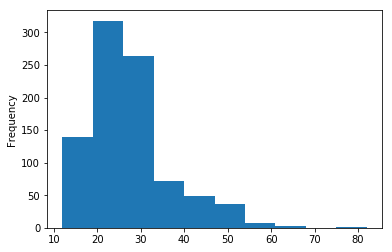

In [29]:
# 劃出每一長度區間次數的長條分布圖(如長度界在10~20之間的有出現約150次)(hint: df[col].plot('hist'))
#=============your works starts===============#
df['name_length'].plot('hist')
#==============your works ends================#


plt.show()

## Fare - PCA, smooth noisy data, feature generation

In [30]:
# 請找出dtype是np.int64或np.float64且名稱不以'_cat'結尾的欄位。
#=============your works starts===============#
number_cols = [col for col in df.columns if df[col].dtype in [np.int64, np.float64] and not col.endswith('_cat')]
#==============your works ends================#


print(number_cols)
# ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'avg_age', 'median_age', 'random_age', 'avg_age_l1', 'avg_age_l2', 'name_length']

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'avg_age', 'median_age', 'random_age', 'avg_age_l1', 'avg_age_l2', 'name_length']


請參照[這個連結](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py)，劃出以下這張PCA圖
![PCA_chart](./imgs/PCA.png)

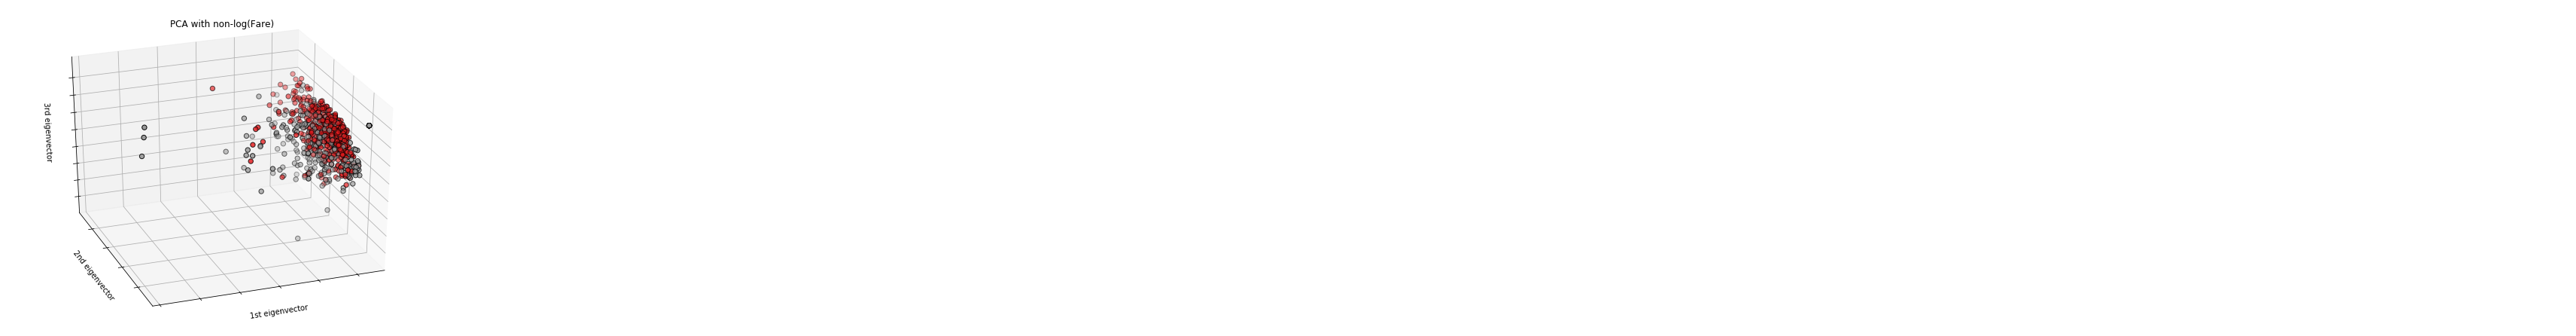

In [46]:
X = df[['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']].values
Y = np.array(df['Survived'])

#!=============your works starts===============!#
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA with non-log(Fare)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
#!==============your works ends================!#

plt.show()

In [32]:
# 請找出標準差最大的欄位['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']
#!=============your works starts===============!#
df[['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']].describe()
#!==============your works ends================!#


,Pclass,Parch,SibSp,Fare,avg_age,name_length
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.381594,0.523008,32.204208,29.699118,26.965208
std,0.836071,0.806057,1.102743,49.693429,13.002015,9.281607
min,1.000000,0.000000,0.000000,0.000000,0.420000,12.000000
25%,2.000000,0.000000,0.000000,7.910400,22.000000,20.000000
50%,3.000000,0.000000,0.000000,14.454200,29.699118,25.000000
75%,3.000000,0.000000,1.000000,31.000000,35.000000,30.000000
max,3.000000,6.000000,8.000000,512.329200,80.000000,82.000000


In [33]:
# 請找出Fare的平均值(mean)，並填入df['Fare']中
#=============your works starts===============#
avg_fare = df['Fare'].mean()
df[pd.isnull(df['Fare'])] = avg_fare
#==============your works ends================#
# df['Fare'].fillna(avg_fare)


print("avg_fare", avg_fare)
# 32.204207968574636
print("number of null of Fare:", len(df[pd.isnull(df['Fare'])]))
# number of null of Fare: 0

avg_fare 32.204207968574636
number of null of Fare: 0


In [34]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [35]:
# 找出Fare==0的row，補上Fare=1
#=============your works starts===============#
df[df['Fare']==0] = 1
#==============your works ends================#

print("number of Fare equals zero:", len(df[df['Fare']==0]))
# number of Fare equals zero: 0

number of Fare equals zero: 0


In [36]:
# 請算出Fare以10為底的log值
#=============your works starts===============#
fare_log10 = np.log10(df['Fare'].values)
#==============your works ends================#


print(fare_log10[:5])
# [0.86033801 1.8529878  0.89899927 1.72509452 0.90579588]

[0.86033801 1.8529878  0.89899927 1.72509452 0.90579588]


In [37]:
df['fare_log10'] = fare_log10
df[['Fare', 'fare_log10']].head()

,Fare,fare_log10
0,7.2500,0.860338
1,71.2833,1.852988
2,7.9250,0.898999
3,53.1000,1.725095
4,8.0500,0.905796


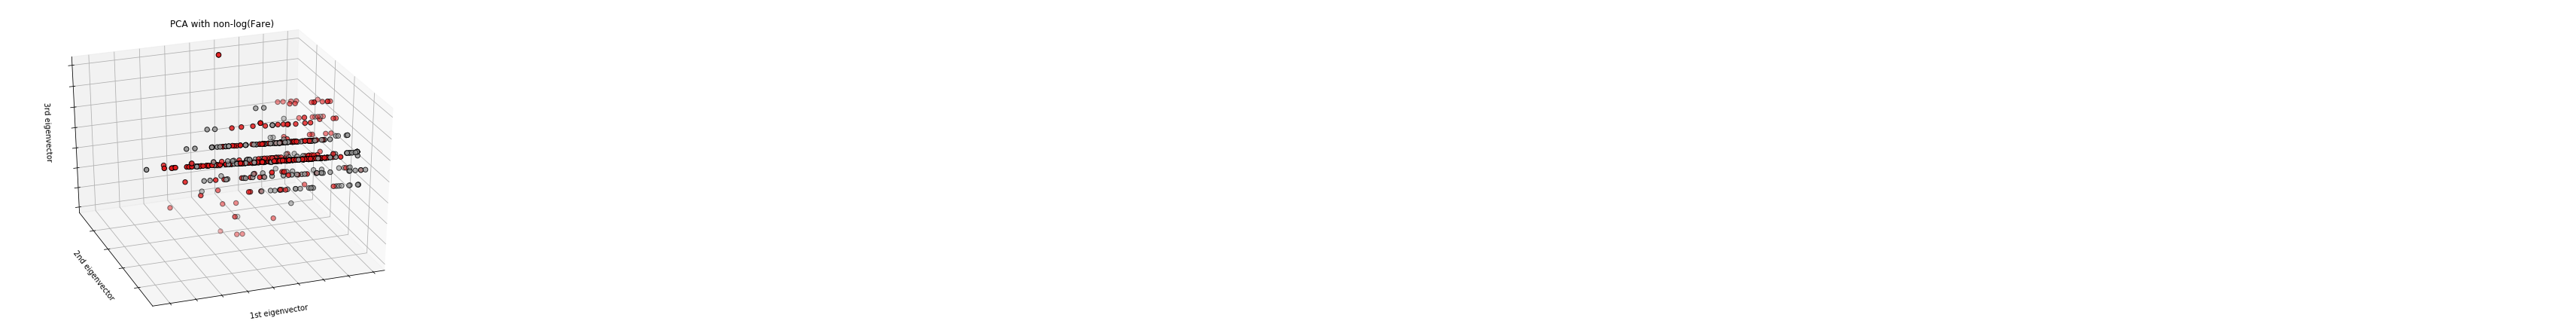

In [38]:
X = np.matrix(df[['Parch', 'SibSp', 'avg_age', 'fare_log10']])
Y = np.array(df['Survived'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA with non-log(Fare)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# 類別型變數onehot encode

In [39]:
enc = preprocessing.OneHotEncoder()
# 請使用enc.fit_transform兩個步驟，onehot encode title_cat
#=============your works starts===============#
title_cat_onehot = enc.fit_transform(df['title_cat'].values.reshape(-1,1)).toarray()
#==============your works ends================#


print(title_cat_onehot[:3])
# [[1. 0. 0. 0. 0.]
#  [0. 0. 1. 0. 0.]
#  [0. 1. 0. 0. 0.]]

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [40]:
enc = preprocessing.OneHotEncoder()
# 請使用enc.fit_transform兩個步驟，onehot encode embarked_cat
#=============your works starts===============#
embarked_cat_onehot = enc.fit_transform(df[['embarked_cat']].values).toarray()
#==============your works ends================#

embarked_cat_onehot[:3]
# array([[0., 0., 1., 0.],
#        [0., 1., 0., 0.],
#        [0., 0., 1., 0.]])

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

# PolynomialFeatures

In [41]:
poly = preprocessing.PolynomialFeatures(degree=2)
# 請利用poly.fit_transform製造出fare_log10的0次項、1次項、2次項，並把0次項拿掉
#=============your works starts===============#
fare_log10_poly = poly.fit_transform(df[['fare_log10']])[:, 1:]
#==============your works ends================#

print(fare_log10_poly[:2])
# [[1.         0.86033801 0.74018149]
#  [1.         1.8529878  3.43356378]]

[[0.86033801 0.74018149]
 [1.8529878  3.43356378]]


In [42]:
# 請利用poly.fit_transform製造出'fare_log10', 'random_age'的二項次及其一次交成項
#=============your works starts===============#
age_fare_ploy = poly.fit_transform(df[['fare_log10', 'avg_age_l1']])[:, 1:]
#==============your works ends================#

print(age_fare_ploy[:2])
# [[8.60338007e-01 8.31383556e-04 7.40181486e-01 7.15270871e-04 6.91198616e-07]
#  [1.85298780e+00 1.43602614e-03 3.43356378e+00 2.66093892e-03 2.06217108e-06]]

[[8.60338007e-01 8.31383556e-04 7.40181486e-01 7.15270871e-04
  6.91198616e-07]
 [1.85298780e+00 1.43602614e-03 3.43356378e+00 2.66093892e-03
  2.06217108e-06]]


## Preprocessing Conclude

In [43]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'avg_age', 'median_age',
       'random_age', 'avg_age_l1', 'avg_age_l2', 'cabin_cat', 'sex_cat',
       'ticket_cat', 'embarked_cat', 'title_cat', 'name_length', 'fare_log10'],
      dtype='object')

In [44]:
X = df[['SibSp', 'Parch', 'avg_age_l2', 'sex_cat', 'name_length', 'fare_log10']].values
X = np.concatenate([X, title_cat_onehot, embarked_cat_onehot, age_fare_ploy], axis=1)
Y = df[['Survived']].values

print(X.shape)
print(Y.shape)

(891, 20)
(891, 1)


In [45]:
from sklearn import linear_model
from  sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1212)

reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
predict_prob = reg.predict(X_test)

Y_predict = predict_prob > 0.5 
Y_test = Y_test == 1
acc = np.sum(Y_predict == Y_test)/ len(Y_test)
print("Accuracy:", acc)


Accuracy: 0.8026905829596412
